In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import PIL.Image as Image
import cv2

# Build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D


#For visualization the model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ResNet - Fine-tuning
from tensorflow.keras.applications import ResNet50

# Os
import os
import numpy as np
import pathlib
import pandas as pd

In [2]:
data_dir = "/kaggle/input/catandrabbit/CatnRabit/train-cat-rabbit" # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/kaggle/input/catandrabbit/CatnRabit/train-cat-rabbit')

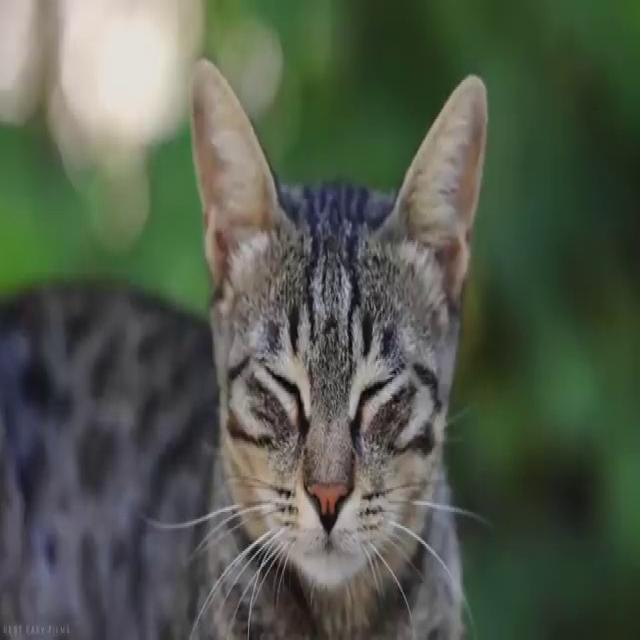

In [3]:
cats = list(data_dir.glob('cat/*'))
Image.open(str(cats[13]))

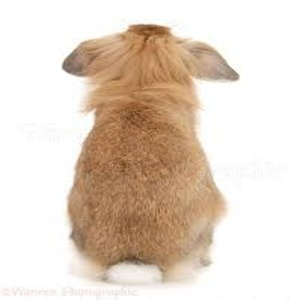

In [4]:
rabbits = list(data_dir.glob('rabbit/*'))
Image.open(str(rabbits[13]))

In [5]:
df_images = {
    'cats' : cats,
    'rabbits' : rabbits
}
df_labels = {
    'cats' : 0,
    'rabbits' : 1,
}

In [6]:
img = cv2.imread(str(df_images['rabbits'][2]))
img.shape
len(df_labels)

2

In [7]:
X, y = [], [] # X = images, y = labels

for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images
        X.append(resized_img) 
        y.append(df_labels[label])

In [8]:
X = np.array(X)
X = X/255
y = np.array(y)

In [9]:
# Separating data into training, test and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [10]:
img_shape = resized_img.shape
num_classes = len(df_labels)

In [11]:
def create_model(input_shape, num_classes) : # With ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers : 
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [12]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
)

datagen.fit(X_train)

In [13]:
model = create_model(resized_img.shape, len(df_labels)) 
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,211,714 (99.99 MB)

 Trainable params: 2,624,002 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
def train_model(X_train, y_train, X_val, y_val, img_shape, num_classes) :
    model = create_model(img_shape, num_classes)
    # Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',   
        patience=20,   
        restore_best_weights=True 
    )
    # Adaptive Learning Rate
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8,     
        patience=3,   
        min_lr=1e-9
    )
    # Model Checkpointing
    model_checkpoint = ModelCheckpoint(
        'best_model.keras',  
        monitor='val_accuracy',
        save_best_only=True 
    )
    #Model Training
    history = model.fit(
        X_train, y_train, 
        epochs=500,  
        validation_data=(X_val, y_val),
        callbacks=[
            early_stopping, 
            reduce_lr,      
            model_checkpoint 
        ],
        batch_size=64  
    )
    return model
model = train_model(X_train, y_train, X_val, y_val, img_shape, num_classes)

Epoch 1/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 364ms/step - accuracy: 0.5130 - loss: 0.7884 - val_accuracy: 0.5370 - val_loss: 0.6862 - learning_rate: 5.0000e-04
Epoch 2/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.5266 - loss: 0.7064 - val_accuracy: 0.5370 - val_loss: 0.6957 - learning_rate: 5.0000e-04
Epoch 3/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.5548 - loss: 0.6912 - val_accuracy: 0.5489 - val_loss: 0.6807 - learning_rate: 5.0000e-04
Epoch 4/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.5466 - loss: 0.6903 - val_accuracy: 0.5513 - val_loss: 0.6760 - learning_rate: 5.0000e-04
Epoch 5/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.5588 - loss: 0.6868 - val_accuracy: 0.5609 - val_loss: 0.6718 - learning_rate: 5.0000e-04
Epoch 6/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.5685 - loss: 0.6769 - val_accuracy: 0.5394 - val_loss: 0.6808 - learning_rate: 5.0000e-04
Epoch 7/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/ste

In [15]:
model.evaluate(X_test, y_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7881 - loss: 0.4548


[0.45527294278144836, 0.7836117744445801]

In [16]:
image = load_img("/kaggle/input/catandrabbit/CatnRabit/show-images/img-4.jpg", target_size=(224, 224))
image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Predict with your model
predicted_probabilities = model.predict(image_array)[0]
predicted_class = np.argmax(predicted_probabilities)

classes = ['Cat', 'Rabbit']

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


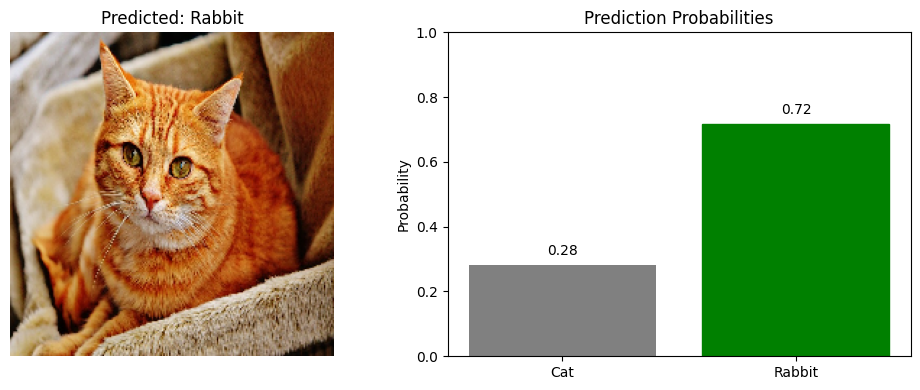

In [17]:
# Create the visualization
fig = plt.figure(figsize=(10, 4))

# Subplot 1: Display the image
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax1.axis('off')
ax1.set_title(f'Predicted: {classes[predicted_class]}')

# Subplot 2: Bar chart for probabilities
ax2 = fig.add_subplot(1, 2, 2)
bars = ax2.bar(classes, predicted_probabilities, color=['gray', 'gray'])
bars[predicted_class].set_color('green')  # Highlight the predicted class in green
ax2.set_ylim(0, 1)
ax2.set_ylabel('Probability')
ax2.set_title('Prediction Probabilities')

# Add probability values on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{predicted_probabilities[i]:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


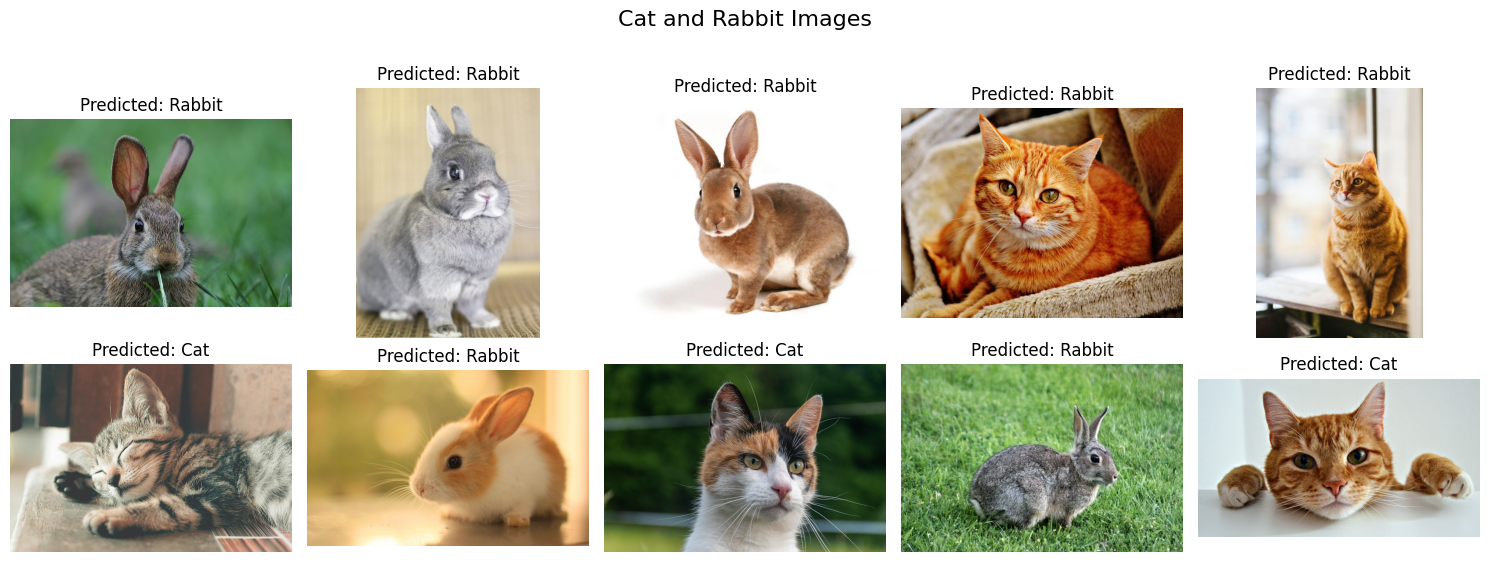

In [18]:
def show_images(model):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Cat and Rabbit Images", fontsize=16)
    
    for i, ax in enumerate(axes.flat, start=1):
        img_path = f"/kaggle/input/catandrabbit/CatnRabit/show-images/img-{i}.jpg"
        try:
            # Load and preprocess the image
            image = load_img(img_path, target_size=(224, 224))
            image_array = img_to_array(image) / 255.0
            image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

            # Predict the class
            predicted_probabilities = model.predict(image_array)[0]
            predicted_class = np.argmax(predicted_probabilities)

            # Display the image
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f'Predicted: {classes[predicted_class]}')
            ax.axis("off")
        
        except Exception as e:
            ax.set_title(f"Error {i}")
            ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Call the function with your model
show_images(model)

In [19]:
model.save("best_model.keras")